In [ ]:
#서울시 부동산 실거래 데이터를 활용해 자치구별/법정동별 거래 금액의 분포를 파악하고, 고가 지역의 특징을 분석
    # 예상: 고가지역은 건물명이 보통 ..., 층수는 보통 ...,신축, ..., 면적이 ...,
# “서울의 부동산 가격은 어디가 높고, 그 이유는 무엇인가?”

In [1]:
import requests  # HTTP 요청을 보내고 응답을 받을 수 있도록 해주는 라이브러리
import xml.etree.ElementTree as ET  # XML 데이터를 파싱(분석)하고 다루기 위한 라이브러리
import pandas as pd  # 데이터프레임을 활용하여 데이터를 효율적으로 처리하기 위한 라이브러리
from datetime import datetime, timedelta  # 날짜 및 시간 계산을 위해 필요한 라이브러리
import numpy as np


In [2]:
# 서울 열린 데이터 광장 인증키 : '745062564a6d6b6a3931664f55684c'
# 서울시 부동산 실거래가 정보(주소 : https://data.seoul.go.kr/dataList/OA-21275/S/1/datasetView.do)

In [ ]:
api_key = 'YOUR_API_KEY'
estate_url = 'http://openapi.seoul.go.kr:8088/'


In [4]:
# 데이터 로드
# API URL 구성 (날짜별 버스 데이터 요청)
url = f'http://openapi.seoul.go.kr:8088/{api_key}/xml/tbLnOpendataRtmsV/1/1000/'

# API 요청을 보냄
response = requests.get(url)  # requests 라이브러리를 사용하여 GET 요청 보내기)
print("답: 상태 코드:", response.status_code)

# XML 응답 데이터를 파싱
root = ET.fromstring(response.content)  # API 응답 데이터를 XML 형식으로 변환)

root

답: 상태 코드: 200


<Element 'tbLnOpendataRtmsV' at 0x000002584E2CDFD0>

In [5]:
# 데이터를 저장할 리스트 생성
estate_data = []

# 목표 : "물건이 비싼 지역과 원인을 분석"
# THING_AMT	- 물건금액(만원)
# CGG_NM	- 자치구명, STDG_CD   - 법정동명
# BLDG_NM - 건물명, ARCH_AREA - 건물 면적, LAND_AREA - 토지 면적, FLR - 층, ARCH_YR - 건축년도

for row in root.findall('.//row'):
    estate_data.append({
        '자치구명': row.find('CGG_NM').text if row.find('CGG_NM') is not None else np.nan,
        # '법정동명': row.find('STDG_CD').text if row.find('STDG_CD') is not None else np.nan, # -> 동까지 필요 없을듯?
        '건물명': row.find('BLDG_NM').text if row.find('BLDG_NM') is not None else np.nan,
        '건물면적': row.find('ARCH_AREA').text if row.find('ARCH_AREA') is not None else np.nan,
        '토지면적': row.find('LAND_AREA').text if row.find('LAND_AREA') is not None else np.nan,
        '층': row.find('FLR').text if row.find('FLR') is not None else np.nan,
        '건축년도': row.find('ARCH_YR').text if row.find('ARCH_YR') is not None else np.nan,
        '물건금액(만원)': row.find('THING_AMT').text if row.find('THING_AMT') is not None else np.nan
    })

estate_data = pd.DataFrame(estate_data)
estate_data

,자치구명,건물명,건물면적,토지면적,층,건축년도,물건금액(만원)
0,금천구,다온빌,29.79,21.000000,2,2021,28000
1,성북구,정릉우성아파트 101~105동,84.99,0.000000,19,2000,65900
2,마포구,KCC상암스튜디오380,20.35,27.690000,13,2014,15000
3,동대문구,롯데캐슬피렌체,30.4,0.000000,14,2009,40000
4,은평구,다베로,40.81,24.000000,3,2017,34500
...,...,...,...,...,...,...,...
995,은평구,골든네스트,54.25,32.000000,4,2017,27000
996,성동구,왕십리자이,59.99,0.000000,18,2017,148000
997,구로구,(796-11),48.12,0.000000,5,1995,23000
998,강서구,정감타운A(346-92),24.97,15.000000,4,2015,18800


In [6]:
estate_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   자치구명      1000 non-null   object
 1   건물명       987 non-null    object
 2   건물면적      1000 non-null   object
 3   토지면적      1000 non-null   object
 4   층         987 non-null    object
 5   건축년도      1000 non-null   object
 6   물건금액(만원)  1000 non-null   object
dtypes: object(7)
memory usage: 54.8+ KB


In [7]:
# 수치형인데 범주형 타입으로 되어있는 피처 타입 변환
num_col = ['건물면적', '토지면적', '층', '건축년도', '물건금액(만원)']

for col in num_col:
    estate_data[col] = pd.to_numeric(estate_data[col], errors='coerce') # coerce : 변환할 수 없는 건 NA 처리

print(estate_data.info())
print(estate_data.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   자치구명      1000 non-null   object 
 1   건물명       987 non-null    object 
 2   건물면적      1000 non-null   float64
 3   토지면적      1000 non-null   float64
 4   층         987 non-null    float64
 5   건축년도      995 non-null    float64
 6   물건금액(만원)  1000 non-null   int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 54.8+ KB
None
자치구명         0
건물명         13
건물면적         0
토지면적         0
층           13
건축년도         5
물건금액(만원)     0
dtype: int64


In [8]:
# 결측치가 매우 적으므로 과감하게 삭제
estate_data = estate_data.dropna()

In [9]:
estate_data.describe().T 
# 토지면적이 이상하고, 건축년도도 0으로 이상함 -> 이상치 탐색 필요

,count,mean,std,min,25%,50%,75%,max
건물면적,982.0,58.925241,26.127744,12.2,37.6425,59.43,84.5125,202.200
토지면적,982.0,12.890127,18.085786,0.0,0.0000,0.00,25.0000,131.608
층,982.0,7.068228,5.578504,-1.0,3.0000,5.00,10.0000,33.000
건축년도,982.0,1984.588595,201.711651,0.0,1997.0000,2004.00,2015.0000,2025.000
물건금액(만원),982.0,76370.693483,65790.468565,7000.0,29125.0000,57500.00,104000.0000,615000.000


In [10]:
print(estate_data['토지면적'].value_counts()) # 토지면적이 0인게 절반 이상 -> 중앙값 대체 or 피처 제거 고려 (우선 제거하겠음)
print(estate_data.drop('토지면적', axis=1, inplace=True))

토지면적
0.0000     561
24.0000     21
19.0000     19
23.0000     18
25.0000     17
          ... 
32.9500      1
55.3099      1
41.9400      1
57.6300      1
50.4200      1
Name: count, Length: 142, dtype: int64
None


C:\Users\SSAFY\AppData\Local\Temp\ipykernel_10056\2169121293.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  print(estate_data.drop('토지면적', axis=1, inplace=True))


In [11]:
# IQR 기반 이상치 탐색 및 제거
def remove_outliers_iqr(df, cols):
    cleaned_df = df.copy()
    for col in cols:
        Q1 = cleaned_df[col].quantile(0.25)
        Q3 = cleaned_df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        before = len(cleaned_df)
        cleaned_df = cleaned_df[(cleaned_df[col] >= lower) & (cleaned_df[col] <= upper)]
        after = len(cleaned_df)

        print(f"[{col}] IQR 범위: {lower:.2f} ~ {upper:.2f}, 제거된 행: {before - after}")

    return cleaned_df

# 적용할 수치형 컬럼
cols_to_check = ['물건금액(만원)', '건물면적', '건축년도']

# 이상치 제거
estate_data_clean = remove_outliers_iqr(estate_data, cols_to_check)

print("\n이상치 제거 후 데이터셋 크기:", estate_data_clean.shape)

[물건금액(만원)] IQR 범위: -83187.50 ~ 216312.50, 제거된 행: 37
[건물면적] IQR 범위: -33.97 ~ 155.23, 제거된 행: 1
[건축년도] IQR 범위: 1970.00 ~ 2042.00, 제거된 행: 9

이상치 제거 후 데이터셋 크기: (935, 6)


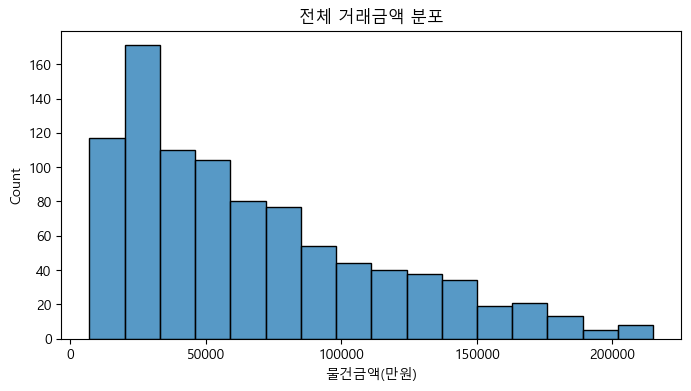

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rc('font', family='Malgun Gothic')  

plt.figure(figsize=(8,4))
sns.histplot(estate_data_clean['물건금액(만원)'])
plt.title('전체 거래금액 분포')
plt.show()

# 긴 꼬리분포

In [13]:
# 자치구별 거래금액 중앙값 계산
by_gu = estate_data_clean.groupby(['자치구명'])['물건금액(만원)'].median().reset_index().sort_values(by='물건금액(만원)', ascending=False)

C:\Users\SSAFY\AppData\Local\Temp\ipykernel_10056\3838833365.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=by_gu,


<Axes: xlabel='물건금액(만원)', ylabel='자치구명'>

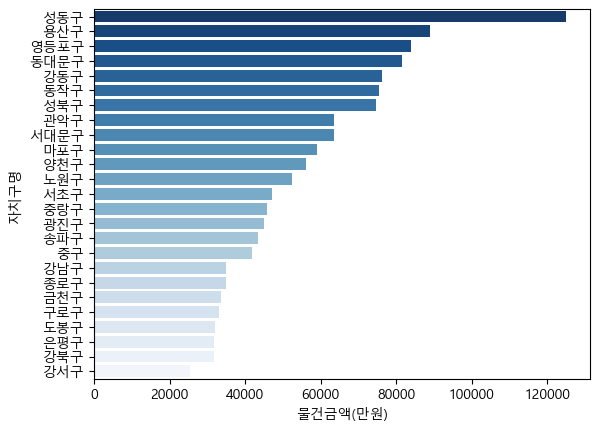

In [14]:
# 시각화로 거래가격이 가장 비싼 자치구들 판별
sns.barplot(data=by_gu, 
            x='물건금액(만원)', y='자치구명', 
            palette='Blues_r')

# 강남구가 압도적으로 1위
# 이후 성동구, 강동구 약간 차이
# 이후 서대문구, 용산구,... 차이 비슷

In [15]:
estate_data_clean.columns

Index(['자치구명', '건물명', '건물면적', '층', '건축년도', '물건금액(만원)'], dtype='object')

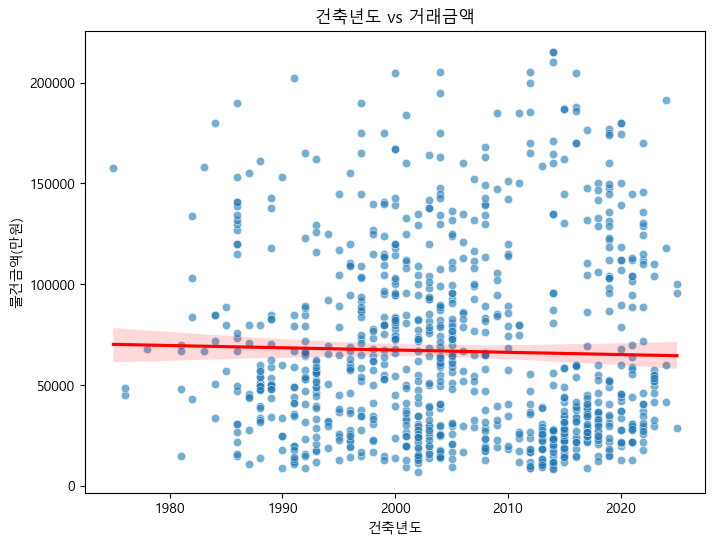

In [16]:
# 건축년도 vs 거래금액
plt.figure(figsize=(8, 6))
sns.scatterplot(data=estate_data_clean, x='건축년도', y='물건금액(만원)', alpha=0.6)
sns.regplot(data=estate_data_clean, x = '건축년도', y='물건금액(만원)', scatter=False, color='red')
plt.title('건축년도 vs 거래금액')
plt.show()

# 예상 외로, '신축일수록 무조건 비싸다'는 아님(= 건축년도는 가격에 직접적 영향이 크지 않음) -> 건물면적, 건물명, 층의 영향이 더 큰가? 확인 필요
# 거래량은 2000년 이후 건물이 거래의 대부분을 차지

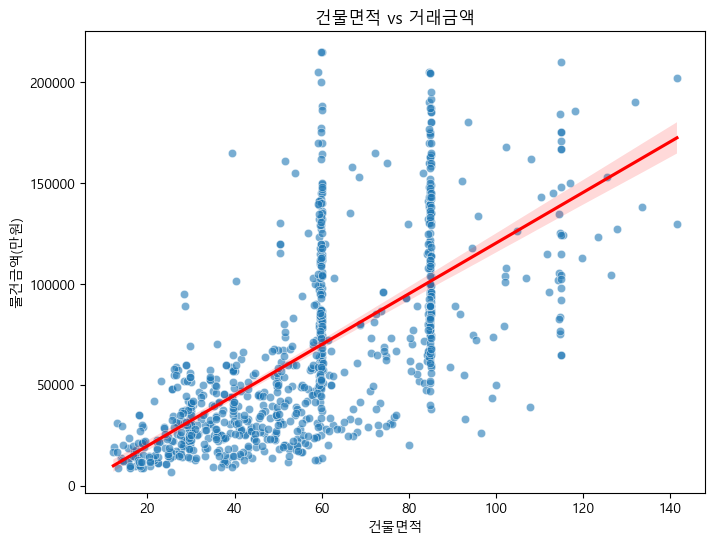

In [17]:
# 건물면적 vs 거래금액
plt.figure(figsize=(8, 6))
sns.scatterplot(data=estate_data_clean, x='건물면적', y='물건금액(만원)', alpha=0.6)
sns.regplot(data=estate_data_clean, x = '건물면적', y='물건금액(만원)', scatter=False, color='red')
plt.title('건물면적 vs 거래금액')
plt.show()

## 당연하게도, 건물 면적이 넓을 수록 거래 금액은 비싸짐!

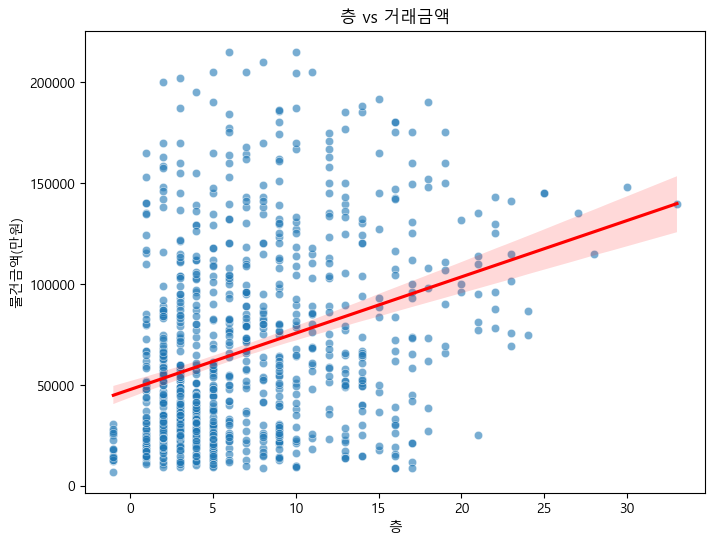

In [18]:
# 층 vs 거래금액
plt.figure(figsize=(8, 6))
sns.scatterplot(data=estate_data_clean, x='층', y='물건금액(만원)', alpha=0.6)
sns.regplot(data=estate_data_clean, x = '층', y='물건금액(만원)', scatter=False, color='red')
plt.title('층 vs 거래금액')
plt.show()

## 층이 높을 수록 거래 금액은 비싸짐!

In [19]:
# 건물에 따른 가격 차이도 클 것 같은데 확인해보자
by_building = (
    estate_data.groupby('건물명')['물건금액(만원)']
    .median().reset_index()
    .sort_values(by='물건금액(만원)',ascending=False)
)

by_building


,건물명,물건금액(만원)
684,청담 르엘,615000.0
249,래미안라클래시,413000.0
653,주공아파트 5단지,399100.0
245,래미안 리더스원,378000.0
314,목동신시가지6,370000.0
...,...,...
682,청광플러스원큐브3차,8900.0
77,강서 동도센트리움,8900.0
95,경동엠파이어스테이트,8900.0
47,JW타워Ⅱ,8750.0


C:\Users\SSAFY\AppData\Local\Temp\ipykernel_10056\642065877.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=by_building,


<Axes: xlabel='물건금액(만원)', ylabel='건물명'>

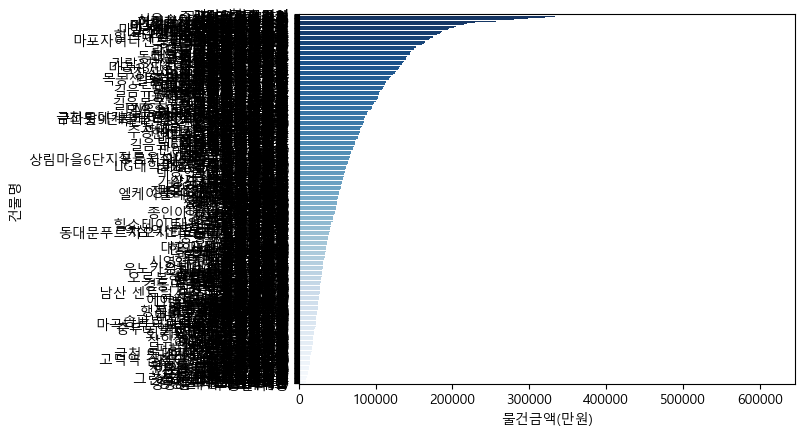

In [20]:
# 시각화로 거래가격이 가장 비싼 건물명 판별
sns.barplot(data=by_building, 
            x='물건금액(만원)', y='건물명', 
            palette='Blues_r')

## 건물명 nunique가 너무 많음 -> 자치구별로 건물명을 봤을 때 어떤 건물명이 비싼지, 그때 그 건물명은 아파트인지 빌라인지,...

  자치구명         층              건물면적         
            mean median       mean   median
0  강남구  9.296296    9.0  48.331741  38.9600
1  강동구  7.425926    5.5  58.974463  59.7175
2  강북구  7.450000    4.5  54.835000  59.3700
3  강서구  6.136364    5.0  47.560030  41.4500
4  관악구  6.204545    4.5  64.251500  59.8550


C:\Users\SSAFY\AppData\Local\Temp\ipykernel_10056\4090445389.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
C:\Users\SSAFY\AppData\Local\Temp\ipykernel_10056\4090445389.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


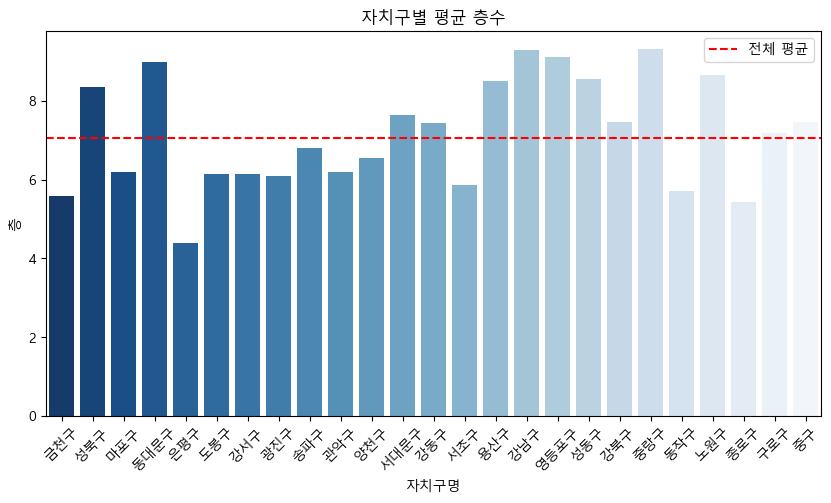

C:\Users\SSAFY\AppData\Local\Temp\ipykernel_10056\4090445389.py:27: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
C:\Users\SSAFY\AppData\Local\Temp\ipykernel_10056\4090445389.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


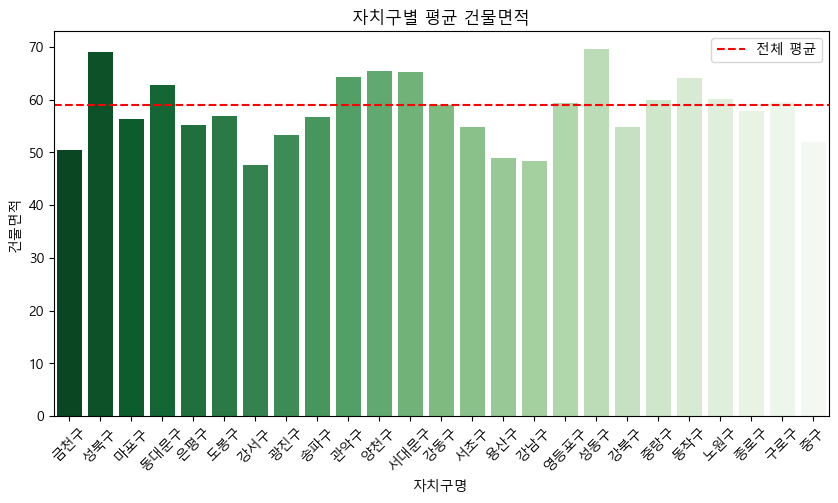

In [21]:
# 자치구별 층수, 건물면적 평균/중앙값
by_gu_features = (
    estate_data.groupby('자치구명')[['층', '건물면적']]
    .agg(['mean', 'median'])
    .reset_index()
)

print(by_gu_features.head())

# 시각화 - 평균 층수
plt.figure(figsize=(10,5))
sns.barplot(
    data=estate_data,
    x='자치구명', y='층',
    estimator='mean',
    ci=None,
    palette='Blues_r'
)
plt.axhline(estate_data['층'].mean(), color='red', linestyle='--', label='전체 평균')
plt.title('자치구별 평균 층수')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# 시각화 - 평균 건물면적
plt.figure(figsize=(10,5))
sns.barplot(
    data=estate_data,
    x='자치구명', y='건물면적',
    estimator='mean',
    ci=None,
    palette='Greens_r'
)
plt.axhline(estate_data['건물면적'].mean(), color='red', linestyle='--', label='전체 평균')
plt.title('자치구별 평균 건물면적')
plt.xticks(rotation=45)
plt.legend()
plt.show()
